In [1]:
# imports
import math
import random
import sys
from collections import deque, namedtuple
from itertools import count

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import ray
import torch
# import AlgorithmConfig
from ray.rllib.algorithms.algorithm import AlgorithmConfig
from ray.rllib.algorithms.dqn import DQN, DQNConfig
from ray.tune.logger import pretty_print

sys.path.append('../..')

from hiv_patient_gym import HIVPatientGym

device: torch.device = torch.device("cpu")

if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("MPS is available")
    device = torch.device("mps")
else:
    print("CUDA is not available")
    device = torch.device("cpu")

print(f"{device=}")
print(torch.__version__)


MPS is available
device=device(type='mps')
1.13.1


In [2]:
ray.shutdown()
ray.init(num_gpus=1, num_cpus=8)

2023-03-21 14:23:59,138	INFO worker.py:1553 -- Started a local Ray instance.


Python version:,3.10.9
Ray version:,2.3.0


In [3]:
epsilon = 1.0

config = (
    DQNConfig(
        {
            "num_workers": 8,
            "num_gpus": 1,
            # "num_envs_per_worker": 1,
            # "num_cpus_per_worker": 1,
            # "num_gpus_per_worker": 0.125,
            "learning_starts": 1000,
            "target_network_update_freq": 100,
            "buffer_size": 100_000,
            "gamma": 0.98,
            "max_episode_len": 200,
            "epsilon": epsilon,  # add the epsilon value to the config
            "exploration_config": {  # add the exploration config
                "type": "EpsilonGreedy",
                "initial_epsilon": epsilon,
                "final_epsilon": 0.05,
                "epsilon_timesteps": 5000,
            },
        }
    )
    .framework("torch")
    .environment(HIVPatientGym)
    # .torch_device(device)
)


# set torch backend to device
config["torch_device"] = device

config.train_batch_size = 50



In [5]:
algo = DQN(config=config)

results = []
best_rewards = [0]

exploration_states = []

for i in range(5):
    # patient.reset(mode="unhealthy")
    
    result = algo.train()
    results.append(result)

    best_rewards.append(result["episode_reward_max"])

    policy = algo.get_policy()
    exploration_states.append(policy.exploration.get_state())

    print(pretty_print(result))

    if best_rewards[-1] > best_rewards[-2] or i % 10 == 0:
        checkpoint = algo.save()
        print("checkpoint saved at", checkpoint)

2023-03-21 14:24:43,669	WARNING util.py:67 -- Install gputil for GPU system monitoring.


ValueError: Expected parameter logits (Tensor of shape (1, 4)) of distribution Categorical(logits: torch.Size([1, 4])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan, nan, nan]])

In [6]:
patient = HIVPatientGym(logscale=True)

policy = algo.get_policy()


In [1]:
states = []
state = patient.reset(mode="unhealthy")
# state = patient.reset(mode="healthy")

total_reward= 0

actions=[]

for i in range(200):
    action, *_ = policy.compute_single_action(state, 
                                            #   explore=False
                                              )
    actions.append(action)

    state, reward, *_ = patient.step(action)
    states.append(state)

    total_reward += reward

print(total_reward * 1e-6)

states_null = []
state = patient.reset(mode="unhealthy")
total_reward_null = 0

# action = patient.action_set[0]
action = 3
for i in range(200):
    # action = greedy_action(DQN, state)
    state, reward, *_ = patient.step(action)
    states_null.append(state)
    total_reward_null += reward

print(total_reward_null * 1e-6)

NameError: name 'patient' is not defined

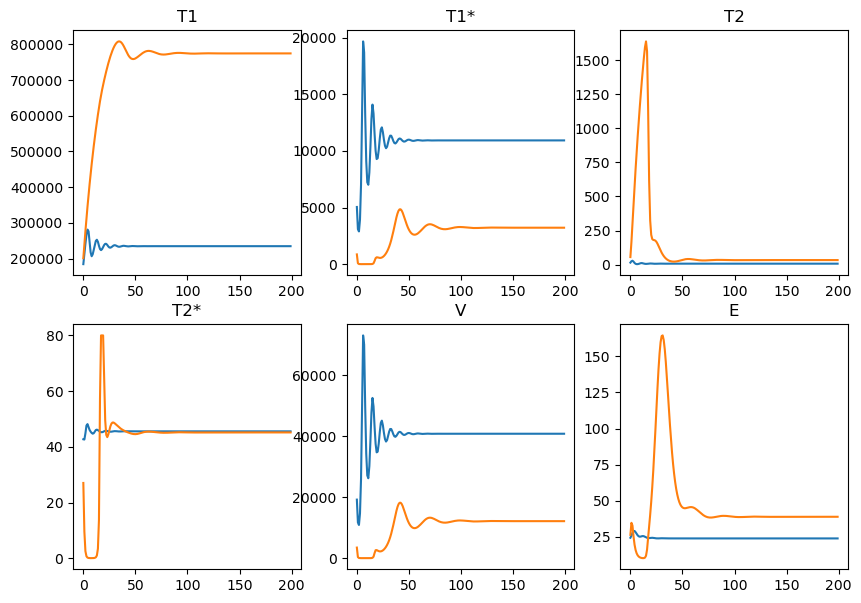

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(10, 7))
npst = np.array(states)
axs[0,0].plot(npst[:,0])
axs[0,0].set_title("T1")
axs[0,1].plot(npst[:,1])
axs[0,1].set_title("T1*")
axs[0,2].plot(npst[:,2])
axs[0,2].set_title("T2")
axs[1,0].plot(npst[:,3])
axs[1,0].set_title("T2*")
axs[1,1].plot(npst[:,4])
axs[1,1].set_title("V")
axs[1,2].plot(npst[:,5])
axs[1,2].set_title("E")

npst = np.array(states_null)
axs[0,0].plot(npst[:,0])
axs[0,1].plot(npst[:,1])
axs[0,2].plot(npst[:,2])
axs[1,0].plot(npst[:,3])
axs[1,1].plot(npst[:,4])
axs[1,2].plot(npst[:,5])


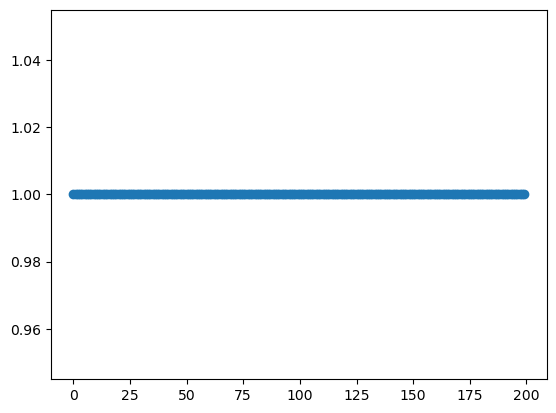

In [9]:
plt.scatter(range(len(actions)), actions)